<a href="https://colab.research.google.com/github/lesi-nedo/ISPR_assignments/blob/main/Assignment_6_o_nedobiychuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center" ><b> <font face="Rage" size=7 >SIFT Descriptors</font></b></div>

<div align="center" ><b> <font face="Rage" size=5 >Assignment 6</font></b></div>
<div align="center" ><b> <font face="Rage" size=4 >Oleksiy Nedobiychuk</font></b></div>


In [ ]:
from google.colab import drive
import os
import cv2



drive.mount('/content/drive/')
uploaded = {}
path = '/content/drive/My Drive/horse/'
for filename in os.listdir(path):
  uploaded[filename] = cv2.cvtColor(cv2.imread(path + filename), cv2.COLOR_BGR2GRAY)



Mounted at /content/drive/


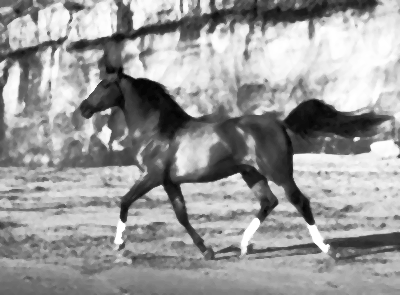

In [21]:
import numpy as np
from google.colab.patches import cv2_imshow
import io


all_images_len = len(uploaded)

last = all_images_len - 1

default_shape = (400,295)
all_images = np.empty([all_images_len, default_shape[1], default_shape[0]], dtype=np.uint8)
gamma = 1.5 # The value for the gamma correction
invGamma = 1.0 / gamma

for ind,(filename,image) in enumerate(uploaded.items()):
  resized = cv2.resize(image, default_shape, interpolation=cv2.INTER_LANCZOS4) # all images are resized

  eq_img = cv2.equalizeHist(resized) # to improve contrast, I've done the histogram equalization
  mdb_img = cv2.medianBlur(eq_img, 3) # to reduce noise, I've blured the image
  table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0,256)]).astype("uint8")
  gcor_img = cv2.LUT(mdb_img, table) #Computes the gamma correction of the image with the table
  all_images[ind] = gcor_img
  uploaded[filename] = gcor_img


cv2_imshow(all_images[0])



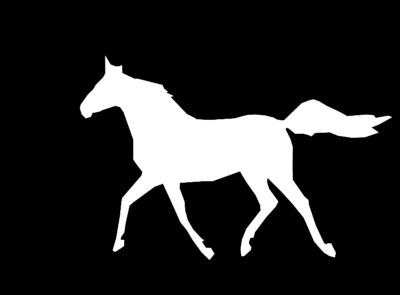

In [22]:
path = '/content/drive/My Drive/horse_mask/'
masks = dict()
for filename in os.listdir(path):
  masks[filename] = cv2.imread(path + filename)
cv2_imshow(masks['horse001_mask.png'])

In [23]:
sift = cv2.SIFT_create()
all_descriptors = []
all_kps = []

def norm_descriptors(desc):
  norms = np.linalg.norm(desc, axis=1, keepdims=True)
  norms[norms == 0] = 1e-8
  return desc / norms
kp = None


for gray in all_images:
  kp = sift.detect(gray, None)
  kp, des = sift.compute(gray, kp)
  all_kps.append(kp)
  des = norm_descriptors(des)
  all_descriptors.append(des)


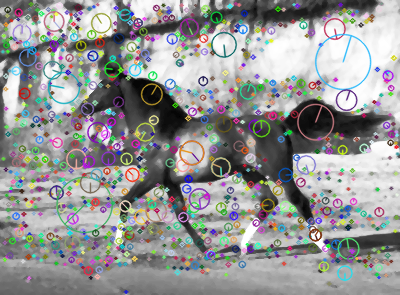

In [24]:
img_with_keypoints = cv2.drawKeypoints(all_images[0], all_kps[0], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2_imshow(img_with_keypoints)

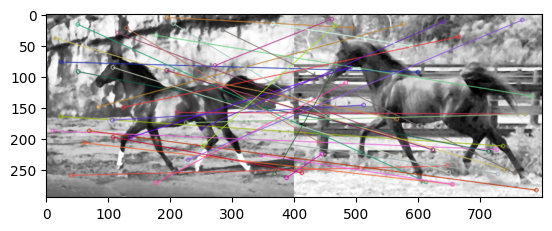

(<matplotlib.image.AxesImage at 0x7a6b1d3e2f20>, None)

In [25]:
import matplotlib.pyplot as plt

bf = cv2.BFMatcher()

matches = bf.knnMatch(all_descriptors[0], all_descriptors[last], k=2)


good_matches = [[0,0] for i in range(len(matches))]

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good_matches[i]=[1,0]


img3 = cv2.drawMatchesKnn(all_images[0], all_kps[0], all_images[last], kp, matches, None, matchesMask=good_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

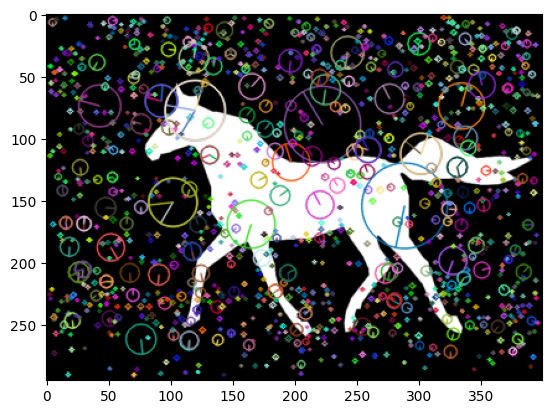

In [26]:
all_descriptors_masks = []
kp_mask = None
horse_mask = masks['horse001_mask.png']
for mask in masks.values():
  kp_mask = sift.detect(mask, None)
  kp_mask, des = sift.compute(mask, kp)
  des = norm_descriptors(des)
  all_descriptors_masks.append(des)

img_with_keypoints = cv2.drawKeypoints(
    horse_mask, kp_mask,
    None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img_with_keypoints)

In [29]:
white_kp = []
black_kp = []
all_kp = len(kp)
ground_truth = np.empty(all_kp, dtype=np.uint8) # 1 horse 0 background

for i,k in enumerate(kp):
  if (horse_mask[int(k.pt[1]), int(k.pt[0])] == 255).all():
    white_kp.append(k)
    ground_truth[i] = 1
  else:
    black_kp.append(k)

white_des = all_descriptors_masks[0][np.where(ground_truth == 1)[0]]
black_des = all_descriptors_masks[0][np.where(ground_truth == 0)[0]]

print(f'Inside the house: {len(white_kp)} -- outside: {len(black_kp)}')


Inside the house: 118 -- outside: 1121


(1313,)


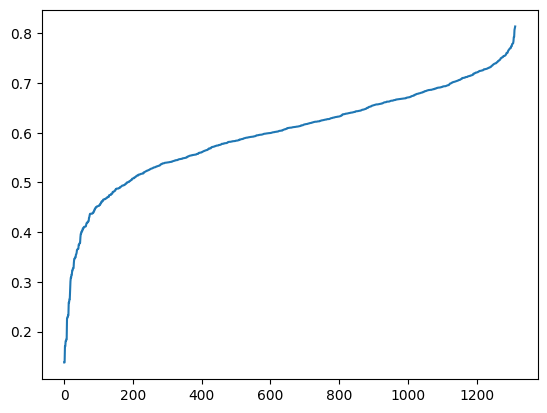

In [30]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
neighbors = NearestNeighbors(n_neighbors=156)
neighbors_fit = neighbors.fit(all_descriptors[0])
distances, indices = neighbors_fit.kneighbors(all_descriptors[0])
distances = np.sort(distances, axis =0)
distances = distances[:, 1]
print(distances.shape)
plt.plot(distances)

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps = 0.46
min_samples = 4
all_labels = []
bad_split = 0
exce_split = 0
rest_splits = 0

clustering = DBSCAN(eps=eps, min_samples=min_samples)
for des in all_descriptors:
  np_d = np.array(des)
  kmeans = clustering.fit_predict(np_d)
  labels = clustering.labels_
  all_labels.append(labels)
  # try:
  s = silhouette_score(np_d, kmeans)
  # except ValueError:
  #   print("Probabily change the eps and min_samples values")
  if s > 0.7:
    exce_split += 1
  elif s < 0.25:
    bad_split += 1
  else:
    rest_splits += 1

print(f'Excellent splits: {exce_split}, Bad Splits: {bad_split}, The rest: {rest_splits}')

Excellent splits: 0, Bad Splits: 327, The rest: 0


1276 marked as noise,  37 marked as part of a cluster


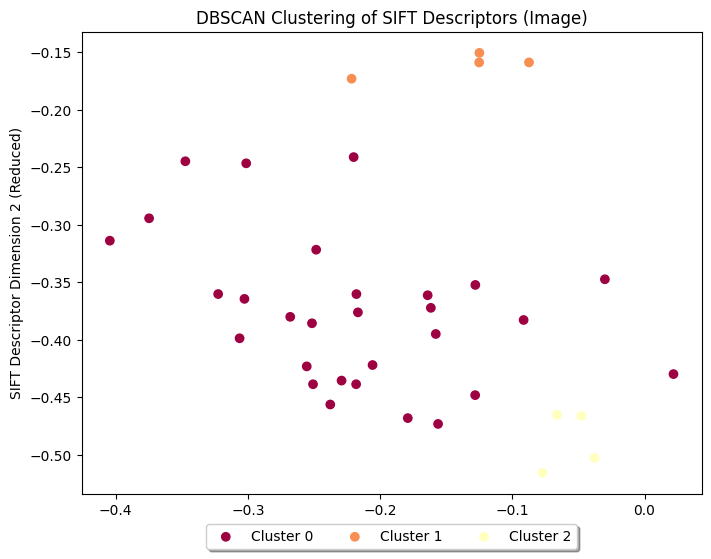

In [96]:
from sklearn.decomposition import PCA
#plotting the cluster of the first image

noise_ = len(all_labels[0][all_labels[0] == -1])
print(noise_, "marked as noise, ", len(all_labels[0]) - noise_, "marked as part of a cluster")

plt.figure(figsize=(8, 6))
def plot_des(all_labels_img, ind=0, alg='DBSCAN', all_descriptors=all_descriptors, message=None):
  pca = PCA(n_components=2)
  reduced_des = pca.fit_transform(all_descriptors[ind])
  unique_lab_ = set(all_labels_img[ind])
  num_unique_val = len(unique_lab_)
  i = 0;
  scatters = list()
  for lab in unique_lab_:
    if lab == -1:
      continue
    labs_ = all_labels_img[ind]
    i += 1
    cluster_ind = np.where(labs_ == lab)[0]

    cl = plt.scatter(reduced_des[cluster_ind, 0], reduced_des[cluster_ind, 1],
                     c=[plt.cm.Spectral(float(i) /num_unique_val) for i in all_labels_img[ind][cluster_ind]])
    scatters.append(cl)

  plt.legend(tuple(scatters),
             tuple([f'Cluster {i}' for i in range(num_unique_val)]),
             scatterpoints=1,
             fontsize=10,
             loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
  plt.xlabel('SIFT Descriptor Dimension 1 (Reduced)')
  plt.ylabel('SIFT Descriptor Dimension 2 (Reduced)')
  plt.title(f'{alg} Clustering of SIFT Descriptors ({message})')
  plt.show()

plot_des(all_labels, 0, message='Image')

Cluster:0 Len: 29
Cluster:1 Len: 4   ------   Cluster:2 Len: 4   ------   

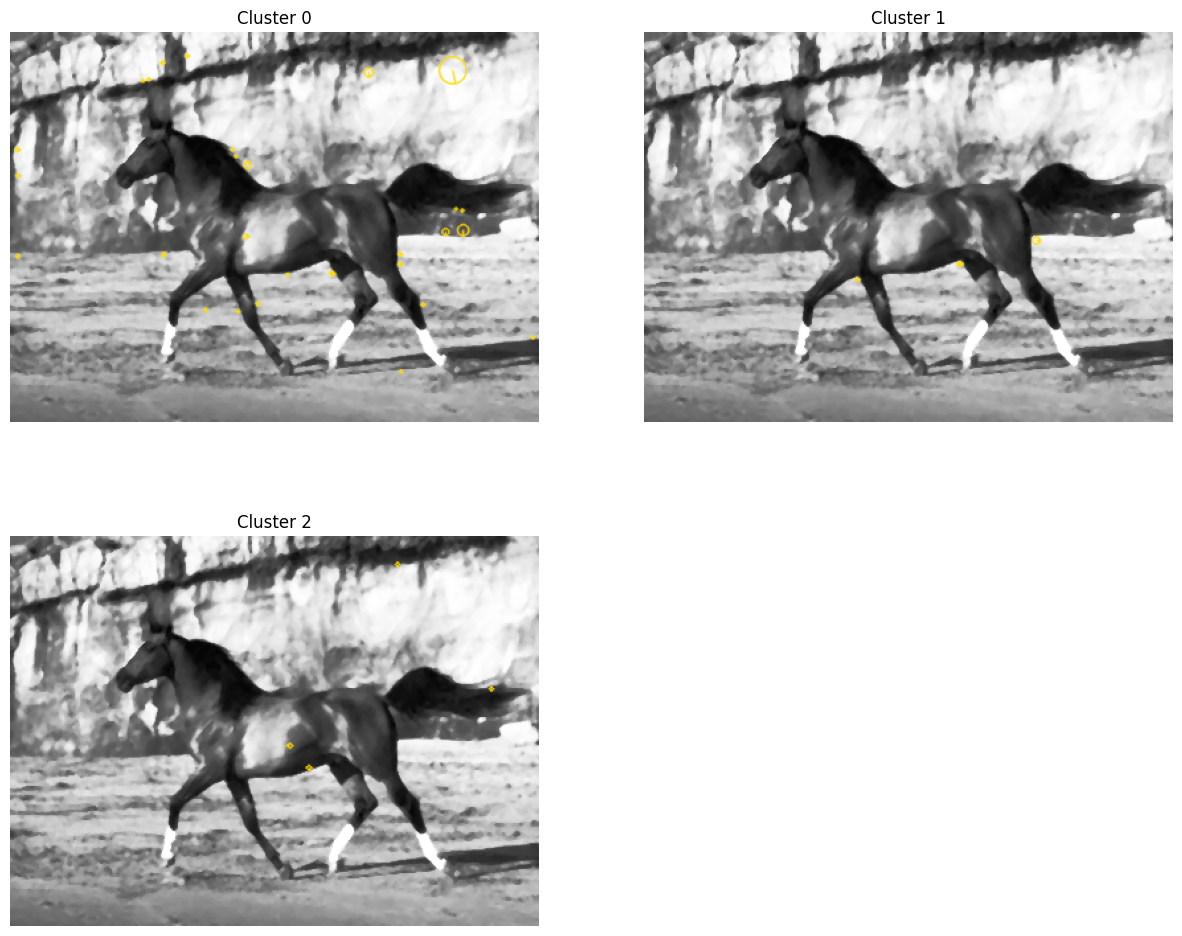

In [100]:
import math
def plot_clust(first_labs, first_kp, image, labels_to_check, cols=2):
  first_kp = np.array(first_kp)
  first_labs = np.array(first_labs)
  fig = plt.figure(figsize=(10, 8))
  n_images = len(labels_to_check)

  for ind,lab in enumerate(labels_to_check):
    clust_i_ind = np.array(np.where(first_labs == lab)[0])
    all_i_cl = first_kp[clust_i_ind]
    end = '   ------   '
    if ind % 3 == 0:
      end = '\n'
    else:
      end = '   ------   '
    print(f'Cluster:{lab} Len: {len(all_i_cl)}', end = end)
    a = fig.add_subplot(cols, math.ceil(n_images/float(cols)), ind + 1)
    img_with_keypoints = cv2.drawKeypoints(
      image, all_i_cl,
      None, color=(255,219,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_with_keypoints)
    plt.axis('off')
    plt.title(f"Cluster {ind}")
  fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/2)
  plt.show()

found_cl = set(all_labels[0])
found_cl.remove(-1)
plot_clust(all_labels[0], all_kps[0], all_images[0], list(found_cl), cols=2)

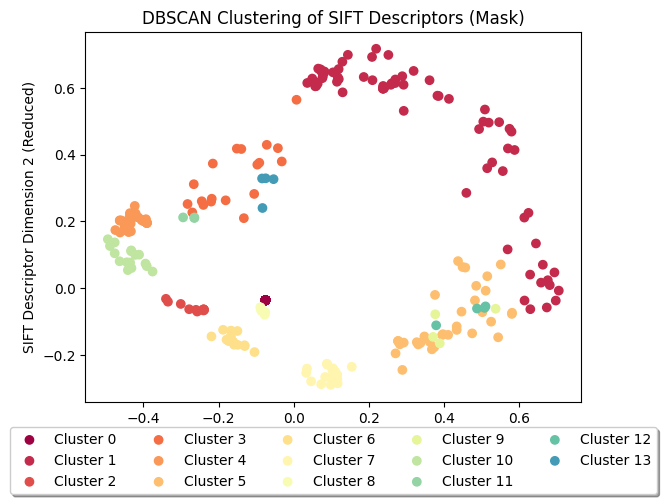

In [97]:
all_labels_mask = []
for des in all_descriptors_masks:
  clustering.fit(des)
  all_labels_mask.append(clustering.labels_)

plot_des(all_labels_mask, ind=0, all_descriptors=all_descriptors_masks, message='Mask')

In [ ]:
found_cl = set(all_labels_mask[0])
found_cl.remove(-1)

plot_clust(all_labels_mask[0], kp_mask, horse_mask, found_cl)

In [103]:
from enum import auto
from sklearn.cluster import KMeans

rest_splits = 0
exce_split = 0
bad_split =0
n_clusters = 2
kmeans = KMeans(n_clusters, random_state=0, n_init='auto')
all_kmean_labels = []
for des in all_descriptors:
  res = kmeans.fit_predict(des)
  all_kmean_labels.append(kmeans.labels_)
  s = silhouette_score(des, res)
  if s > 0.7:
    exce_split += 1
  elif s < 0.25:
    bad_split += 1

print(f'Excellent splits: {exce_split}, Bad Splits: {bad_split}, Rest split: {rest_splits}')



Excellent splits: 0, Bad Splits: 327, Rest split: 0


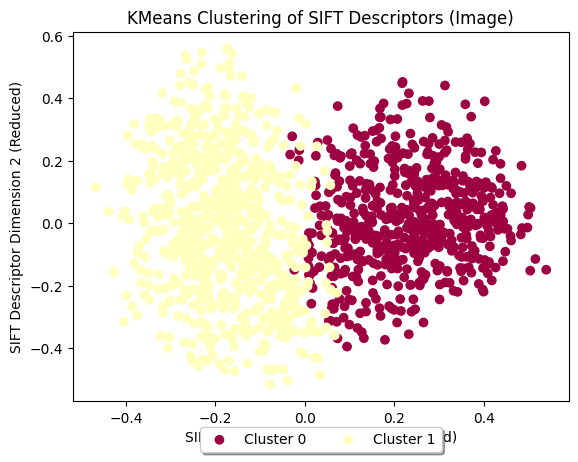

In [112]:
plot_des(all_kmean_labels, ind=0, alg='KMeans', message='Image')


Cluster:0 Len: 574
Cluster:1 Len: 739   ------   

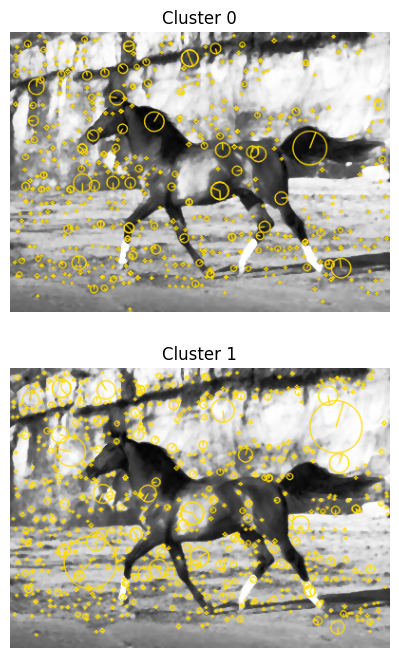

In [115]:
plot_clust(all_kmean_labels[0], all_kps[0], all_images[0], [0, 1], cols=2)

Excellent splits: 0, Bad Splits: 327, Rest split: 0


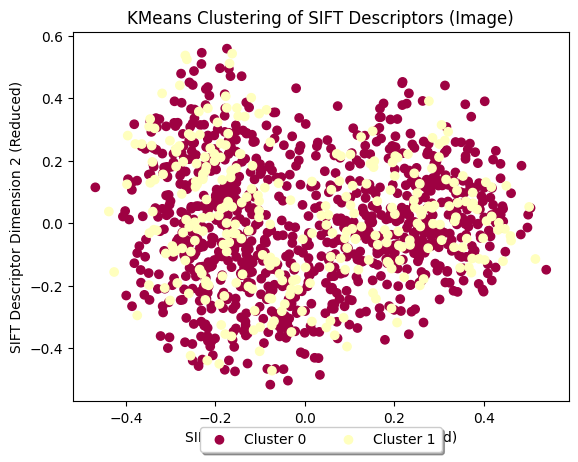

In [116]:

all_kmean_labels_mask = []
for des in all_descriptors_masks:
  res = kmeans.fit_predict(des)
  all_kmean_labels_mask.append(kmeans.labels_)
  s = silhouette_score(des, res)
  if s > 0.7:
    exce_split += 1
  elif s < 0.25:
    bad_split += 1

print(f'Excellent splits: {exce_split}, Bad Splits: {bad_split}, Rest split: {rest_splits}')
plot_des(all_kmean_labels_mask, ind=0, alg='KMeans', message='Image')



Cluster:0 Len: 939
Cluster:1 Len: 300   ------   

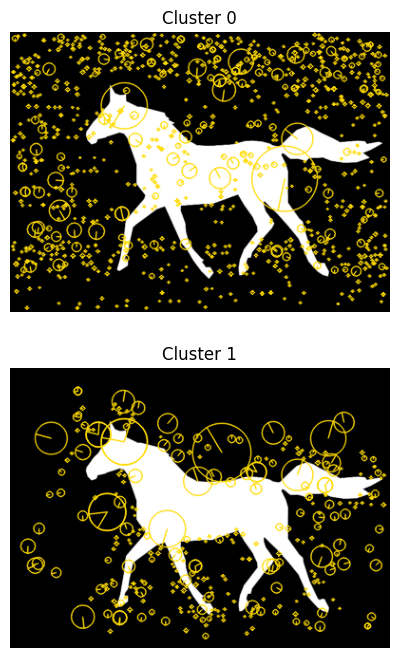

In [120]:
plot_clust(all_kmean_labels_mask[0], kp_mask, horse_mask, [0, 1], cols=2)